In [223]:
import os 
import numpy as np 
import math
from scipy.stats import linregress

from NirsLabProject.config.consts import *
from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.utils import sleeping_utils
from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import plotting


In [ ]:
subjects_stats = {
    TIMESTAMP_INDEX: {},
    AMPLITUDE_INDEX: {},
    DURATION_INDEX: {},
    GROUP_FOCAL_AMPLITUDE_INDEX: {},
    GROUP_EVENT_DURATION_INDEX: {},
    GROUP_EVENT_SIZE_INDEX: {},
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: {},
    GROUP_EVENT_DEEPEST_INDEX: {},
    GROUP_EVENT_SHALLOWEST_INDEX: {},
}

feature_id_to_title = {
    TIMESTAMP_INDEX: 'Spike Rate Average',
    AMPLITUDE_INDEX: 'Spike Amplitude Average',
    DURATION_INDEX: 'Spike Width Average',
    GROUP_FOCAL_AMPLITUDE_INDEX: 'Spike Group Focal Amplitude',
    GROUP_EVENT_DURATION_INDEX: 'Spike Group Event Duration Average',
    GROUP_EVENT_SIZE_INDEX: 'Spike Group Event Size Average',
    GROUP_EVENT_SPATIAL_SPREAD_INDEX: 'Spike Group Event Spatial Spread Average',
    GROUP_EVENT_DEEPEST_INDEX: 'Spike Group Event Deepest Electrode Avrage',
    GROUP_EVENT_SHALLOWEST_INDEX: 'Spike Group Event Shallowest Electrode Avrage',
}

stimuli_subjects = putils.get_subjects(
    filters=[
        lambda subj: subj.stimuli_project,
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
    ],
    sort_key=lambda subj: subj.p_number,
)
subjects = {
    s: s for s in stimuli_subjects
}

nrem_subjects_blocks = {}
subjects_blocks = {}
subject_block_durations = {}
for subj, stimuli_subjects in subjects.items():
    block_durations = putils.get_blocks_duration(subj)
    subject_block_durations[subj] = {
        'before window': block_durations[0],
        'stim block': block_durations[1],
        'pause block': block_durations[2],
        'after window': block_durations[4],
    }
    
    if subj == stimuli_subjects:
        if os.path.exists(subj.paths.subject_sleep_scoring_path):
            nrem_data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=True)
            data_of_blocks = putils.get_stimuli_subject_blocks(subj, only_nrem=False)
        else:
            print(f'stimuli {subj.p_number}')
            continue
    else:
        print(f'control {subj.p_number} with {stimuli_subjects.p_number}')
        if os.path.exists(subj.paths.subject_hypnogram_path):
            nrem_data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=True)
            data_of_blocks = get_control_subject_blocks(subj, stimuli_subjects, only_nrem=False)
        else:
            continue
    nrem_subjects_blocks[subj] = nrem_data_of_blocks
    subjects_blocks[subj] = data_of_blocks

block_names = ['before window', 'stim block', 'pause block', 'after window']


In [ ]:
def is_group_valid(group):
    for block_name, block_value in group.items():
        if not np.isnan(block_value):
            return True
    return False

## Seperators

In [ ]:
def temporal_frontal_seperator(block_features, subj, feature_index):
        groups = ['temporal', 'frontal']
        frontal_chans = ['ROF', 'LOF', 'RAC', 'LAC', 'LAF', 'RAF', 'RFA', 'RIF-dAC', 'LOPR']
        temporal_chans = ['RA', 'LA', 'RAH', 'LAH', 'RMH', 'LMH', 'REC', 'LEC', 'RPHG', 'LPHG']
        index_to_channel_name = np.load(subj.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
        channel_name_to_index = {channel_name: index for index, channel_name in index_to_channel_name.items()}
        frontal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in frontal_chans if f'{chan}{i}' in channel_name_to_index]
        temporal_chans = [channel_name_to_index[f'{chan}{i}'] for i in range(1,8) for chan in temporal_chans if f'{chan}{i}' in channel_name_to_index]

        
        frontal_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], frontal_chans))][:, feature_index])
            for block_name, features in block_features.items()
        }
        
        frontal_counts = {
            block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], frontal_chans))][:, feature_index].shape[0]
            for block_name, features in block_features.items()
        }
        
        temporal_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], temporal_chans))][:, feature_index])
            for block_name, features in block_features.items()
        } 
        
        temporal_counts = {
            block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], temporal_chans))][:, feature_index].shape[0]
            for block_name, features in block_features.items()
        } 
        
        means = {
            groups[0]: temporal_manes,
            groups[1]: frontal_manes,
        }
        
        counts =  {
            groups[0]: temporal_counts,
            groups[1]: frontal_counts,
        }
        
        return groups, means, counts
    
def nrem_seperator(block_features, subj, feature_index):
        groups = ['NREM', 'REM/Wake']
        nrem_mean = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] == HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items()
        }
        
        rest_mean = {
            block_name: np.mean(features[features[:, HYPNOGRAM_FLAG_INDEX] != HYPNOGRAM_FLAG_NREM][:, feature_index])
            for block_name, features in block_features.items()
        } 
        
        means = {
            groups[0]: nrem_mean,
            groups[1]: rest_mean,
        }
        
        nrem_count = {
            block_name: features[features[:, HYPNOGRAM_FLAG_INDEX] == HYPNOGRAM_FLAG_NREM][:, feature_index].shape[0]
            for block_name, features in block_features.items()
        }
        
        rest_count = {
            block_name: features[features[:, HYPNOGRAM_FLAG_INDEX] != HYPNOGRAM_FLAG_NREM][:, feature_index].shape[0]
            for block_name, features in block_features.items()
        } 
        
        counts = {
            groups[0]: nrem_count,
            groups[1]: rest_count,
        }
        
        return groups, means, counts
    

def temporal_frontal_soze(block_features, subj, feature_index):
    groups = ['temporal', 'frontal']
    temporal_soz = [485, 487, 488, 496, 497, 498, 515, 520, 544]
    frontal_soz = [486, 499, 505, 5101, 5107]

    temporal_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], temporal_soz))][:, feature_index])
        for block_name, features in block_features.items()
    } 

    temporal_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], temporal_soz))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items()
    } 

    frontal_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], frontal_soz))][:, feature_index])
        for block_name, features in block_features.items()
    }

    frontal_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], frontal_soz))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items()
    }

    means = {
        groups[0]: temporal_manes,
        groups[1]: frontal_manes,
    }

    counts =  {
        groups[0]: temporal_counts,
        groups[1]: frontal_counts,
    }

    return groups, means, counts

def contra_ipsi_inter_subjects_seperator(block_features, subj, feature_index):
    groups = ['contra', 'ipsi']
    contra_stim = [486, 487, 488, 489, 498, 499, 5101, 5107, 538, 544]
    ipsi_stim = [485, 496, 505, 515]

    contra_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], contra_stim))][:, feature_index])
        for block_name, features in block_features.items()
    } 

    contra_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], contra_stim))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items()
    } 

    ipsi_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, SUBJECT_NUMBER], ipsi_stim))][:, feature_index])
        for block_name, features in block_features.items()
    }

    ipsi_counts = {
        block_name: features[np.where(np.isin(features[:, SUBJECT_NUMBER], ipsi_stim))][:, feature_index].shape[0] or np.nan
        for block_name, features in block_features.items()
    }

    means = {
        groups[0]: contra_manes,
        groups[1]: ipsi_manes,
    }

    counts =  {
        groups[0]: contra_counts,
        groups[1]: ipsi_counts,
    }

    return groups, means, counts

def contra_ipsi_seperator(block_features, subj, feature_index):
    groups = ['contra', 'ipsi']
    stim_side_right = [485, 487, 489, 490, 496, 497, 5101, 5107, 515, 520, 538, 544, 545]
    stim_side = 'R' if subj.p_number in stim_side_right else 'L'
    
    index_to_channel_name = np.load(subj.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
        
    contra_chans = [i for i, n in index_to_channel_name.items() if n[0] != stim_side]
    ipsi_chans = [i for i, n in index_to_channel_name.items() if n[0] == stim_side]
    
    contra_manes = {
            block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], contra_chans))][:, feature_index])
            for block_name, features in block_features.items()
    }

    contra_counts = {
        block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], contra_chans))][:, feature_index].shape[0]
        for block_name, features in block_features.items()
    }

    ipsi_manes = {
        block_name: np.mean(features[np.where(np.isin(features[:, CHANNEL_INDEX], ipsi_chans))][:, feature_index])
        for block_name, features in block_features.items()
    } 

    ipsi_counts = {
        block_name: features[np.where(np.isin(features[:, CHANNEL_INDEX], ipsi_chans))][:, feature_index].shape[0]
        for block_name, features in block_features.items()
    } 

    means = {
        groups[0]: contra_manes,
        groups[1]: ipsi_manes,
    }

    counts =  {
        groups[0]: contra_counts,
        groups[1]: ipsi_counts,
    }
    
    print(subj.p_number, 'ipsi: ', ipsi_counts, [index_to_channel_name[i] for i in ipsi_chans])

    return groups, means, counts


In [ ]:
types = {
    'temporal-frontal': {
        'groups': ['temporal', 'frontal'],
        'seperator_function': temporal_frontal_seperator
    },
     'temporal-frontal-soze': {
        'groups': ['temporal', 'frontal'],
        'seperator_function': temporal_frontal_soze
    },
     'contra-ipsi-inter-subject-stimuli': {
        'groups': ['contra', 'ipsi'],
        'seperator_function': contra_ipsi_inter_subjects_seperator
    },
    'contra-ipsi-stimuli': {
        'groups': ['contra', 'ipsi'],
        'seperator_function': contra_ipsi_seperator
    },
    
    'NREM-REMorWake': {
        'groups': ['NREM', 'REM/Wake'],
        'seperator_function': nrem_seperator
    }
}

for _type in types:
    for compare_to_base_line in [True, False]:
        results = {}
        groups = types[_type]['groups']
        for feature_index in subjects_stats.keys():
            is_group_feature = GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX or feature_index in [GROUP_FOCAL_AMPLITUDE_INDEX]
            prefix = 'group ' if is_group_feature else ''
            if compare_to_base_line:
                _block_names = block_names[1:]
            else:
                _block_names = block_names[:]
            results[feature_index] = {
                block_name: {group: [] for group in groups} for block_name in _block_names
            }
            groups_size = [0, 0]
            for subject in subjects.keys():
                groups, groups_menas, groups_counts = types[_type]['seperator_function'](subjects_blocks[subject], subject, feature_index)        
                for gi, group in enumerate(groups):
                    if is_group_valid(groups_menas[group]):
                        groups_size[gi] += 1   
                    else:
#                         pass
                        print(f'Subject {subject.p_number} | Group {group} is not valid')

                    group_data = groups_menas[group]
                    for block_name in _block_names:
                        block_data = group_data[prefix+block_name]
                        base_line_data = group_data[prefix+'before window']
                        if feature_index == TIMESTAMP_INDEX:
                            block_data = groups_counts[group][block_name] / subject_block_durations[subject][block_name]
                            base_line_data = groups_counts[group]['before window'] / subject_block_durations[subject]['before window']
                        
                        if np.isnan(block_data):
                            continue
                            
                        if compare_to_base_line:
                            results[feature_index][block_name][group].append(
                                putils.baseline_diff(base_line_data, block_data)
                            )
                        else:
                            results[feature_index][block_name][group].append(
                               block_data
                            )

        subject = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
        path = os.path.join(subject.paths.subject_stimuli_effects_plots_dir_path, _type)
        if not os.path.exists(path):
            os.makedirs(path)

        for feature_index, stats in results.items():
            plotting.create_box_plot_for_stimuli(
                figure_path=path,
                groups_size=groups_size,
                data_channels=results[feature_index],
                feature_name=('Baseline - ' if compare_to_base_line else 'Raw - ') + feature_id_to_title[feature_index],
            )

In [ ]:
import os
import mne
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mne.time_frequency import tfr_morlet
import scipy.io as sio
from nilearn import plotting


from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.subject import Subject
from NirsLabProject.config.consts import *


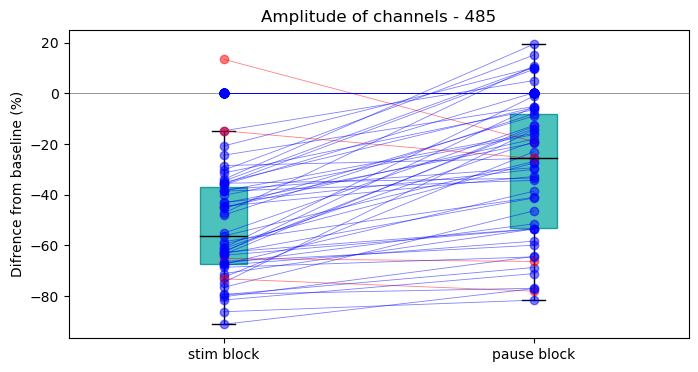

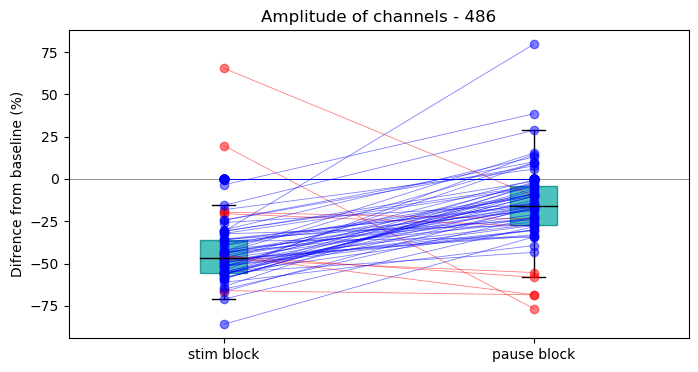

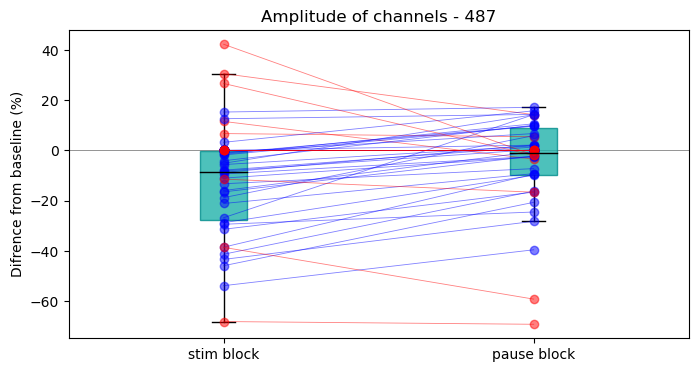

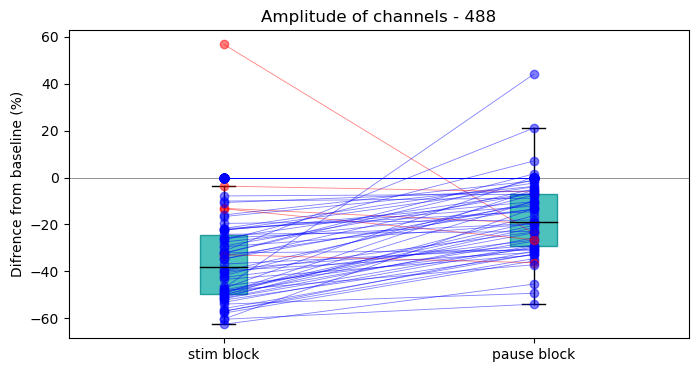

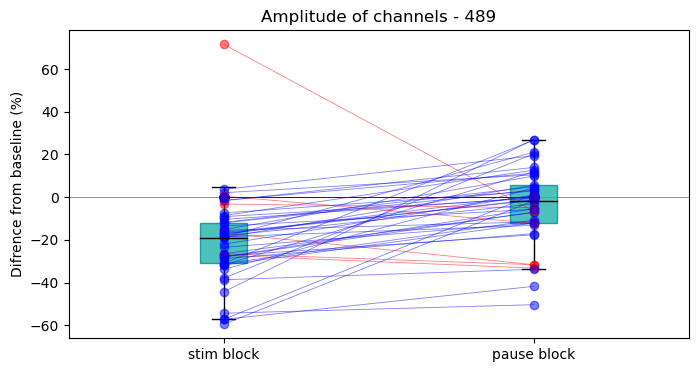

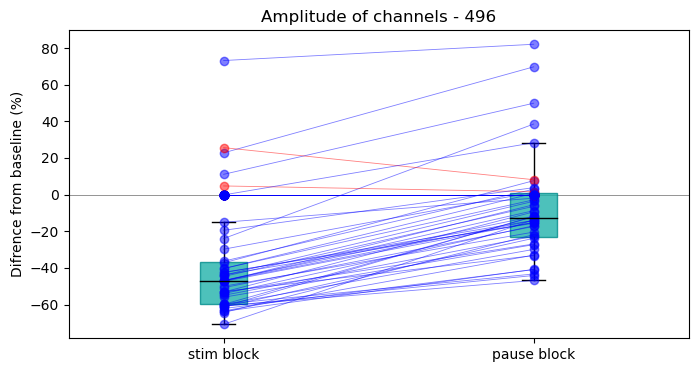

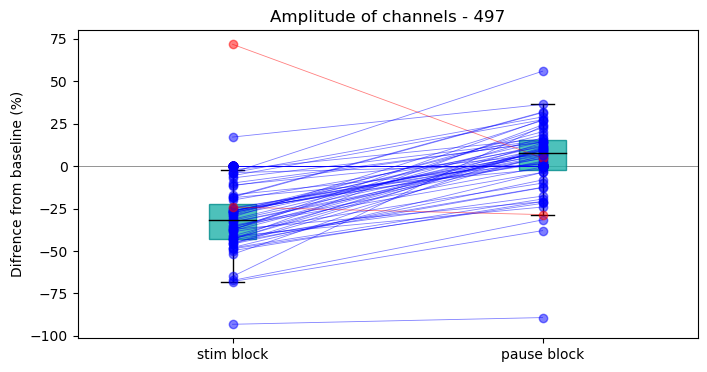

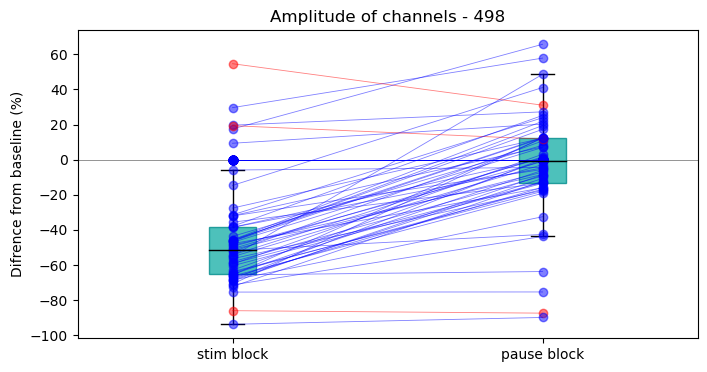

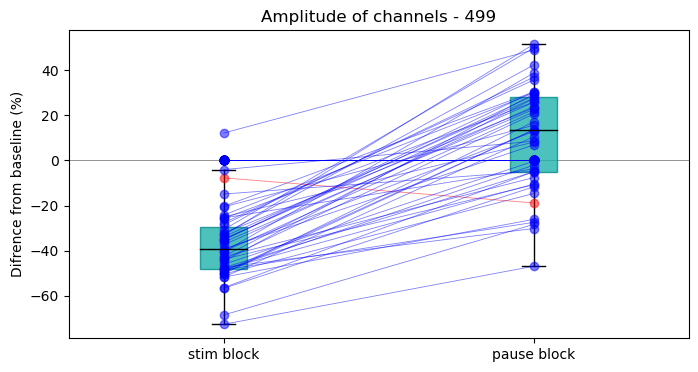

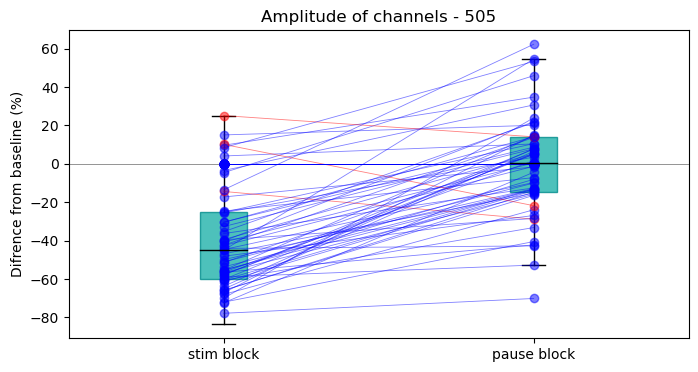

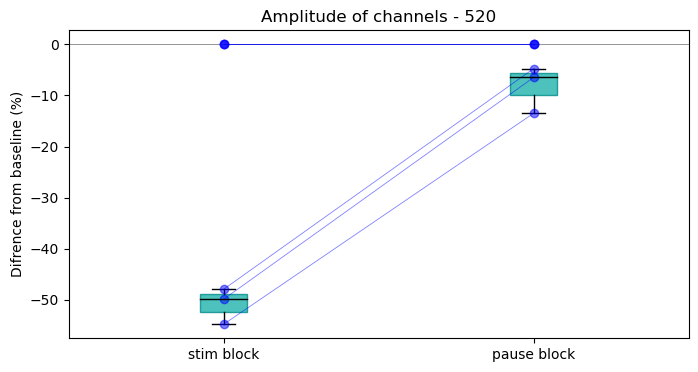

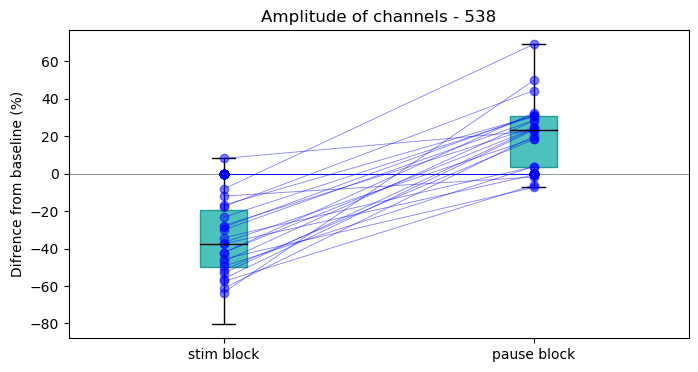

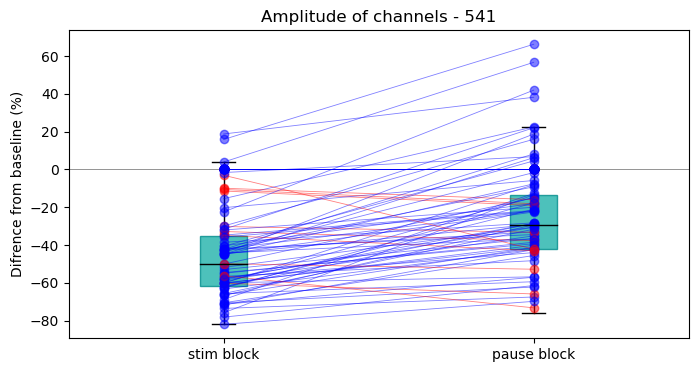

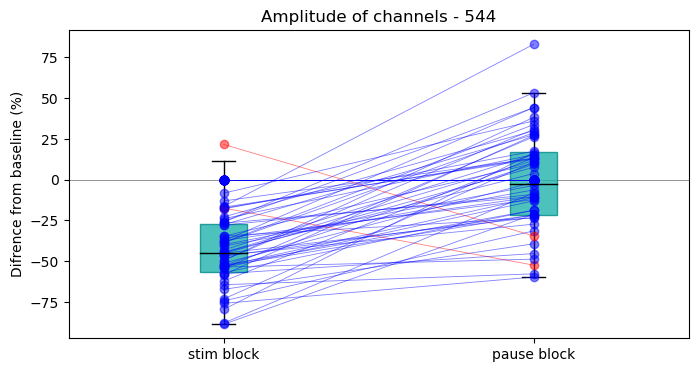

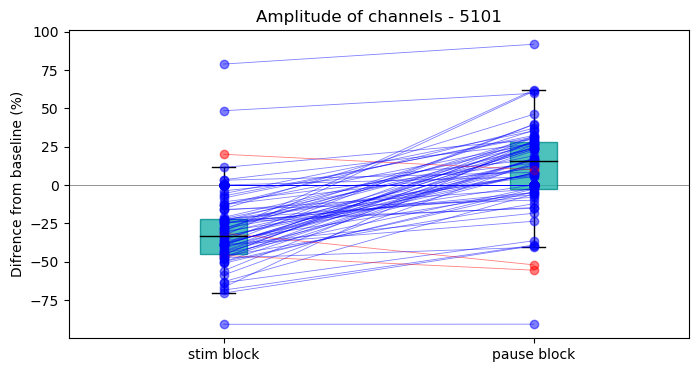

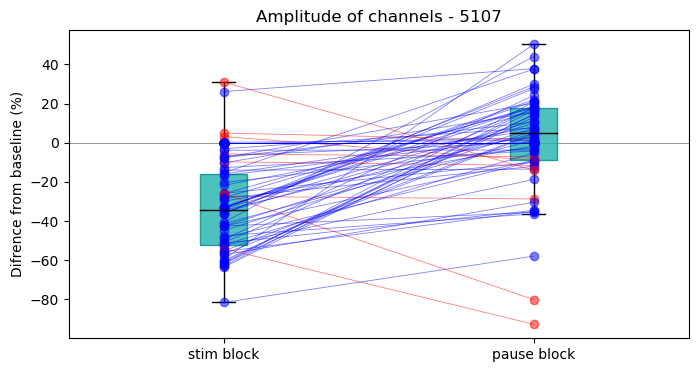

In [230]:
def create_box_plot_for_stimuli(figure_path: str, data_channels: Dict[str, np.array], data_channels_linear: Dict[str, np.array], feature_name: str, show: bool = False):
    fig, ax = plt.subplots(figsize=(8, 4))
    data = []
    for key, values in data_channels.items():
        data.append([value for value in values if not np.isnan(value)])

    # add horizontal line at y=0
    ax.axhline(y=0, color='dimgrey', linewidth=0.5, zorder=1)
    # Boxplot data
    bp = ax.boxplot(
        x=data,
        vert=True,
        patch_artist=True,
        zorder=2,
        showfliers=False
    )

    # change the color of the boxplots
    box_plots_colors = ['lightseagreen', 'indianred']
    box_plots_edges_colors = ['darkcyan', 'firebrick']
    for idx, patch in enumerate(bp['boxes']):
        patch.set_facecolor(box_plots_colors[0])
        patch.set_alpha(0.8)
        patch.set_edgecolor(box_plots_edges_colors[0])

    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    
    scatter_colors = ['blue', 'red', ]
    # add al points as scatter plot next to the boxplot
    for channel, values in data_channels_linear.items():
        if any(v is None for v in values) or any(np.isnan(v) for v,_ in values):
            continue
        points = [v for v in values]
        color_index = int(points[0] > points[-1])
        ax.plot(range(1,len(points)+1), points, 'ro-', alpha=0.5, linewidth=0.6, color=scatter_colors[color_index])

    # x axis ticks
    if len(data) == len(data_channels):
        plt.xticks(np.arange(1, len(data_channels) + 1, 1), data_channels.keys())
    else:
        plt.xticks(np.arange(1, 2 * len(data_channels), 2) + 0.5, data_channels.keys())

    # y axis ticks
    plt.ylabel('Difrence from baseline (%)')

    # title
    plt.title(f"{feature_name}")   

    fig.savefig(
        fname=os.path.join(figure_path, feature_name),
        bbox_inches='tight',
        dpi=300
    )

    if show:
        plt.show()



for subject in subjects.keys():
    channels_spikes_features = np.load(
        subject.paths.subject_channels_spikes_features_path,
        allow_pickle=True
    ).item()
    index_to_channel = putils.get_index_to_channel(subject, channels_spikes_features)
    channel_values = {block: [] for block in block_names[1:-1]}
    channel_values_linear = {ch: [None, None] for ch in index_to_channel.values()}
    subject_data = subjects_blocks[subject]
    for i, block_name in enumerate(_block_names[1:-1]):
        for channel_index, channel_name in index_to_channel.items():
            if channel_name.startswith('C'):
                continue
            block_data = subject_data[prefix+block_name]
            base_line_data = subject_data[prefix+'before window']           
            block_mean = block_data[block_data[:, CHANNEL_INDEX] == channel_index][:,AMPLITUDE_INDEX].mean()
            base_line_mean = base_line_data[base_line_data[:, CHANNEL_INDEX] == channel_index][:,AMPLITUDE_INDEX].mean()
            channel_values[block_name].append(
                putils.baseline_diff(base_line_mean, block_mean)
            )
            channel_values_linear[channel_name][i] = (putils.baseline_diff(base_line_mean, block_mean), color)
    all_subjects = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
    path = os.path.join(all_subjects.paths.subject_stimuli_effects_plots_dir_path, 'Channels Amplitudes')
    if not os.path.exists(path):
        os.makedirs(path)
    create_box_plot_for_stimuli(
        figure_path=path,
        data_channels=channel_values,
        data_channels_linear=channel_values_linear,
        feature_name=(f'Amplitude of channels - {subject.p_number}'),
    )
        


calculating coordinates for subject 485
calculating coordinates for subject 486
calculating coordinates for subject 487
calculating coordinates for subject 488
calculating coordinates for subject 489
calculating coordinates for subject 496
calculating coordinates for subject 497
calculating coordinates for subject 498
calculating coordinates for subject 499
Could not find the stimulating electrode for subject 505
skipping subject 505 - no stimuli location
calculating coordinates for subject 520
calculating coordinates for subject 538
calculating coordinates for subject 541
calculating coordinates for subject 544
calculating coordinates for subject 5101
calculating coordinates for subject 5107


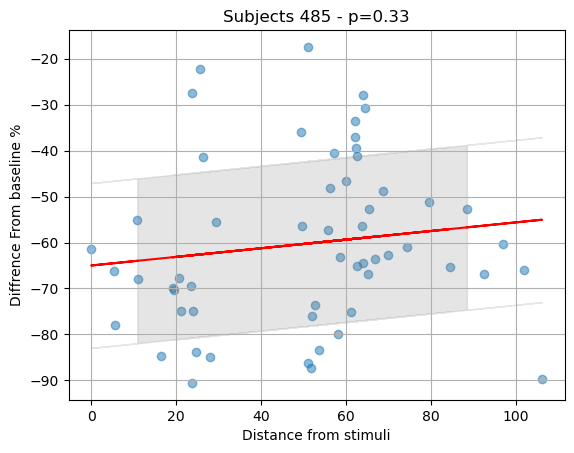

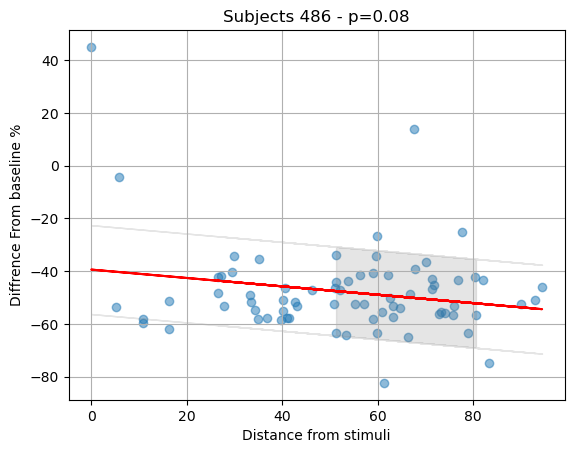

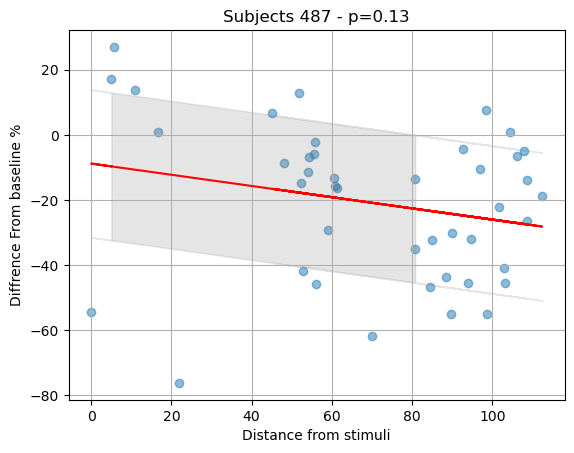

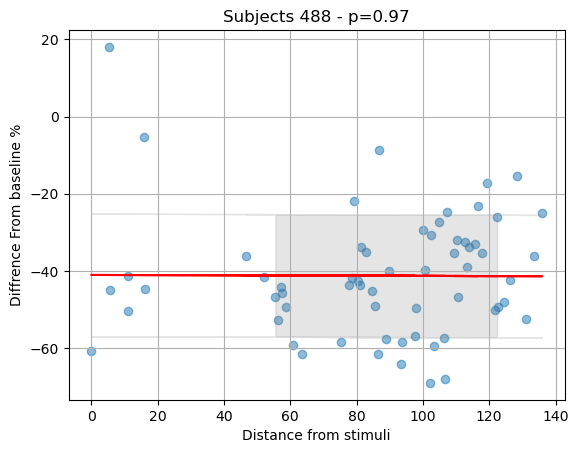

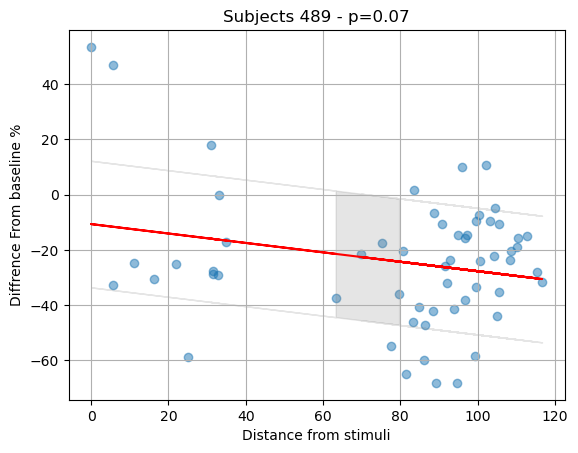

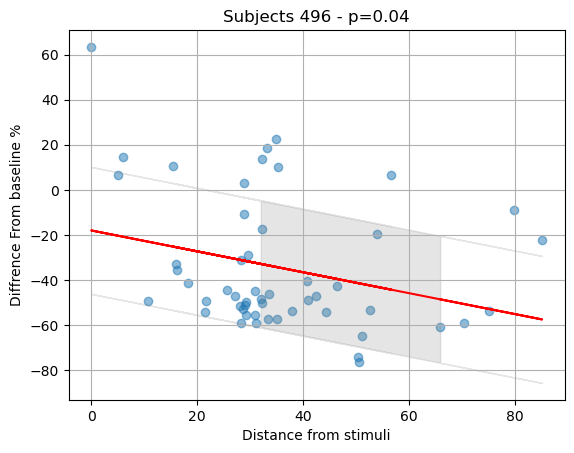

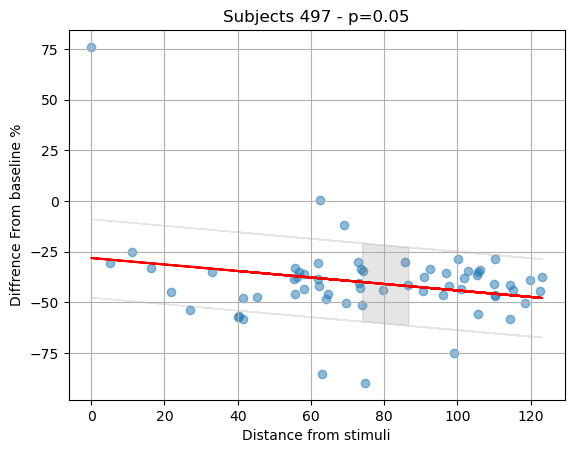

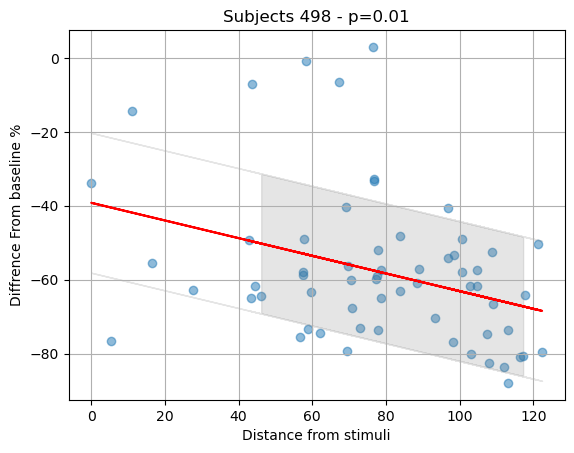

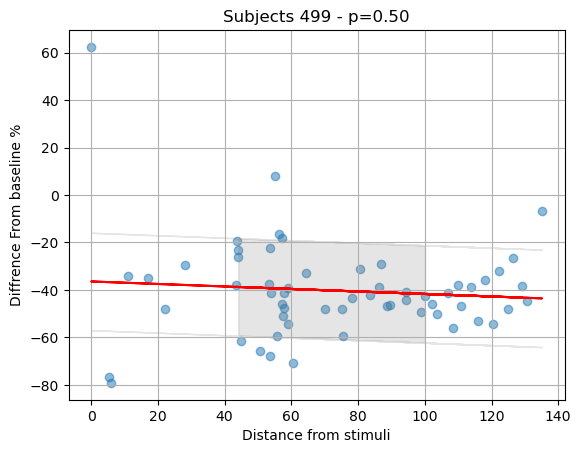

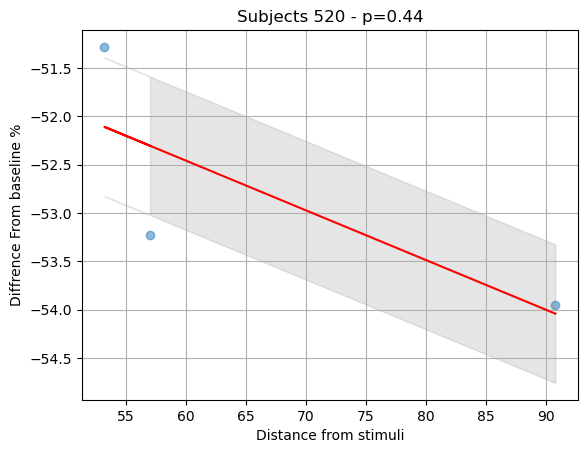

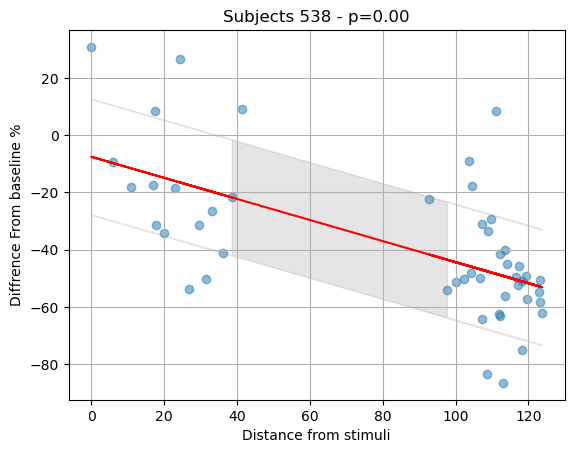

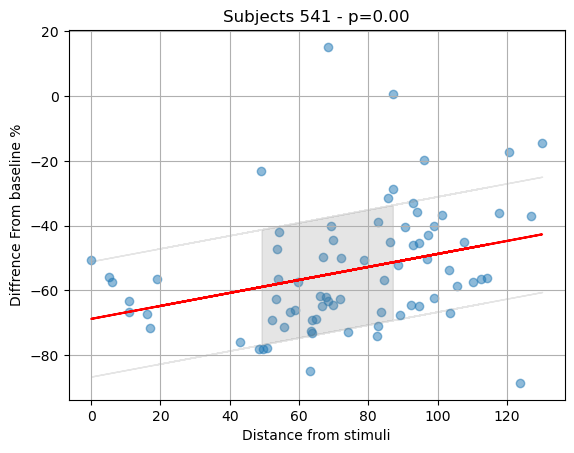

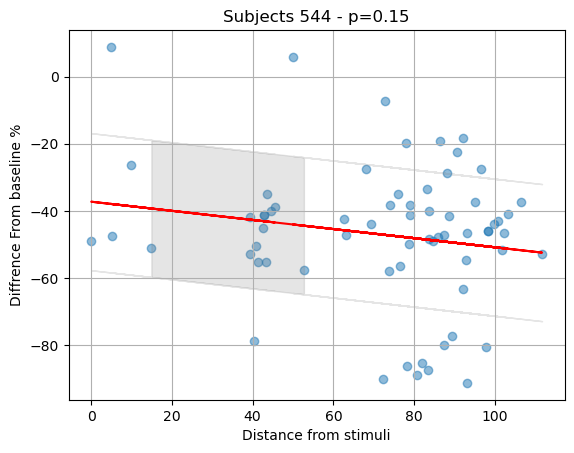

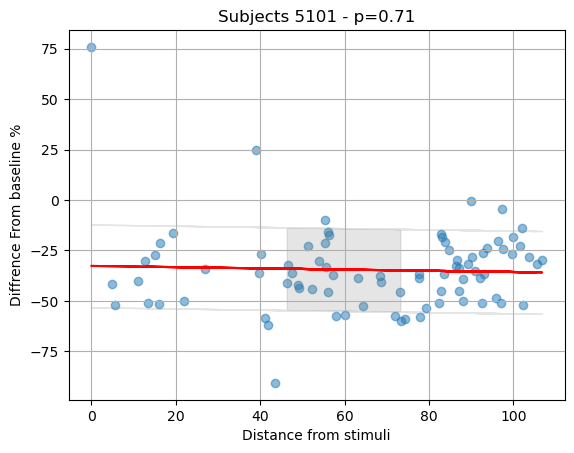

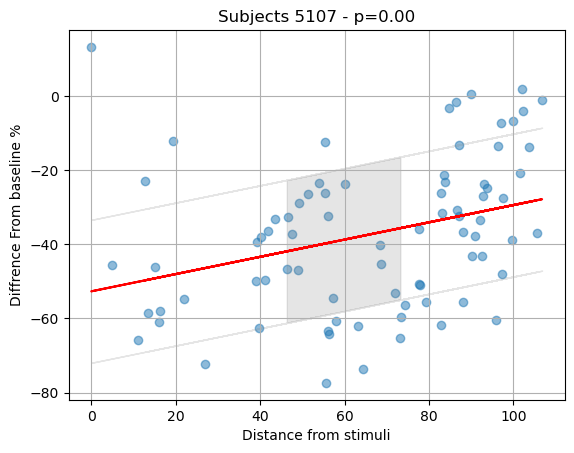

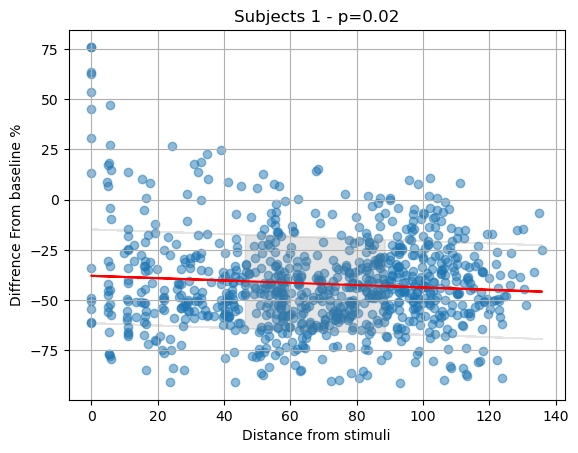

In [239]:
def distance(point1, point2):
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    return distance

def plot(channel_values, subject):
    fig, ax = plt.subplots()
    # Plot each subject's data as a line plot
    x_values = [x for x,_ in channel_values]
    y_values = [y for _, y in channel_values]
    ax.scatter(x_values, y_values, label=subj, alpha=0.5, linewidth=1)
    
    slope, intercept = np.polyfit(x_values, y_values, 1)
    correlation_line = [slope * x + intercept for x in x_values]

    # Calculate standard deviation
    residuals = np.array(y_values) - np.array(correlation_line)
    std = np.std(residuals)
    
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

    
    plt.plot(x_values, correlation_line, color='red', label='Correlation Line')
    
    ax.set_ylabel('Diffrence From baseline %')
    ax.set_xlabel('Distance from stimuli')
    title = f'Subjects {subject.p_number}'
    ax.set_title(title + f' - p={p_value:.2f}')

    # Plot standard deviation bands
    plt.fill_between(x_values, np.array(correlation_line) - std, np.array(correlation_line) + std, color='gray', alpha=0.2, label='± 1 Std Dev')
    plt.grid(True)
    
    all_subjects = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
    path = os.path.join(all_subjects.paths.subject_stimuli_effects_plots_dir_path, 'Amplitude - Distance')
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(os.path.join(subject.paths.subject_stimuli_effects_plots_dir_path, path, f'{title}.png'), bbox_inches='tight')

all_channel_values = []
for subject in subjects.keys():
    stimuli_channels = utils.pars_stimuli_locations_file(subject)
    if not stimuli_channels:
        print(f'skipping subject {subject.p_number} - no stimuli location')
        continue
    stimuli_channel = stimuli_channels[0]
    stimuli_channel = 'ROPR-AI1' if stimuli_channel == 'ROPRAI1' else stimuli_channel
    ch_to_cord = utils.calculate_coordinates(subject)
    stimuli_p = ch_to_cord[stimuli_channel]
    
    channels_spikes_features = np.load(
        subject.paths.subject_channels_spikes_features_path,
        allow_pickle=True
    ).item()
    index_to_channel = putils.get_index_to_channel(subject, channels_spikes_features)
    channel_values = []
    subject_data = subjects_blocks[subject]
    for channel_index, channel_name in index_to_channel.items():
        block_data = subject_data['stim block']
        base_line_data = subject_data['before window']           
        channel_block_data = block_data[block_data[:, CHANNEL_INDEX] == channel_index]
        block_mean = channel_block_data[:,AMPLITUDE_INDEX].mean()
        channel_base_line_data = base_line_data[base_line_data[:, CHANNEL_INDEX] == channel_index]
        base_line_mean = channel_base_line_data[:,AMPLITUDE_INDEX].mean()
        if channel_block_data.shape[0] == 0:
            continue
        channel_p = channel_block_data[0, CORD_X_INDEX:CORD_Z_INDEX+1]
        d = distance(stimuli_p, channel_p)
        mean = putils.baseline_diff(base_line_mean, block_mean)
        if np.isnan(d) or np.isnan(mean):
            continue
        channel_values.append(
            (
                d,
                mean,
            )
        )
    plot(channel_values, subject)
    all_channel_values.extend(channel_values)
plot(all_channel_values, Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True))


    
            
    